In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var, summary
import sys
sys.path.append('/home/tomek/ib_tools')
import matplotlib.pyplot as plt
%matplotlib inline
from tester import run, simulate, calibrate, calibrate_multiple

In [2]:
def ema(data, periods, smooth, vol):
    data = data.copy()
    data['ema_fast'] = data.close.ewm(span=periods).mean()
    data['ema_slow'] = data.close.ewm(span=periods*4).mean()
    data['ema_diff'] = data.ema_fast - data.ema_slow
    data['ema_diff_norm'] = data.ema_diff / vol 
    #data.ema_diff.ewm(span=vol_lookback).std()
    #data['ema_diff_norm'] = data.ema_diff / data.ema_diff.rolling(periods).std()
    data[f'ema_{periods}'] = data['ema_diff_norm'].ewm(span=int(periods/2)).mean()
    #data[f'ema_{periods}'] = data['ema_diff_norm']
    return data[f'ema_{periods}']

In [3]:
def reducer(x):
    if x < -2.7:
        return max(-(np.log(np.abs(x) -2.7) - .5), 0)
    elif x > 2.7:
        return min((np.log(np.abs(x) -2.7) - .5), 0)
    else:
        return - x**3

In [4]:
def bolli(data, periods, smooth, vol):
    data = data.copy()
    data['mid'] = data.close.ewm(span=periods).mean()
    data['distance'] = data.mid - data.close
    data['std'] = data.close.ewm(span=periods).std()
    data['distance_scaled'] = data.distance / data['std']
    data[f'bolli_{periods}'] = data['distance_scaled']
    return data[f'bolli_{periods}']

In [5]:
def bolli_reduced(data, periods, smooth, vol):
    data = data.copy()
    #data[f'bolli_reduced_{periods}'] = smooth(bolli(data, periods, smooth, vol).apply(reducer), periods/3)
    data[f'bolli_reduced_{periods}'] = bolli(data, periods, smooth, vol).apply(reducer)
    return data[f'bolli_reduced_{periods}']

In [6]:
def breakout(data, periods, smooth, vol):
    up  = (data.close >= data.close.rolling(periods).max()) * 1
    down = (data.close <= data.close.rolling(periods).min()) * 1
    return (up - down).ewm(span=max((int(periods/3), 1))).mean().rename(f'break_{periods}', inplace=True)

In [7]:
def carver(data, periods, smooth, vol):
    data = data.copy()
    data['max'] = data.close.rolling(periods).max()
    data['min'] = data.close.rolling(periods).min()
    data['mid'] = data[['min', 'max']].mean(axis=1)
    data['breakout'] = data['close'] - data['mid']
    data['breakout_norm'] = data['breakout'] / (data['max'] - data['min'])
    data[f'carver_{periods}'] = smooth(data['breakout_norm'], periods/3)
    return data[f'carver_{periods}']

In [8]:
def roc(data, periods, smooth, vol):
    data = data.copy()
    data['roc'] = data.close.pct_change(periods) * 100
    #data['std'] = data['roc'].ewm(span=200).std()
    #data['roc_normalized'] = data['roc'] / data['std']
    data['roc_normalized'] = data['roc']
    data[f'roc_{periods}'] = smooth(data['roc_normalized'], periods/3)
    return data[f'roc_{periods}']

In [9]:
def roca(data, periods, smooth, vol):
    data = data.copy()
    data['roc'] = data.close.diff()
    #data['std'] = data['roc'].ewm(span=200).std()
    #data['roc_normalized'] = data['roc'] / data['std']
    data['roc_normalized'] = data['roc'] / vol
    data[f'roc_{periods}'] = smooth(data['roc_normalized'], periods/3)
    return data[f'roc_{periods}']

In [10]:
def momentum(data, periods, smooth, vol):
    data = data.copy()
    data['ema'] = data.close.ewm(span=periods).mean()
    data['momentum'] = data['close'] - data['ema']
    data['momentum_normalized'] = data['momentum'] / vol
    data[f'momentum_{periods}'] = smooth(data['momentum_normalized'], periods/3)
    return data[f'momentum_{periods}']

In [11]:
sym = 'NQ'
func = breakout
periods = [40, 80, 160, 320, 640, 1280, 2500, 5000, 10000]
start_date = '20190101'

In [12]:
s= '20180501'
params = {
    #'bolli_reduced': calibrate_multiple(sym, bolli_reduced, start_date=s, periods=periods),
    #'ema': calibrate_multiple(sym, ema, start_date=s, periods=periods),
    'breakout': calibrate_multiple(sym, breakout, start_date=s, periods=periods),
    #'carver': calibrate_multiple(sym, carver, start_date=s, periods=periods, adjustment=40),
    #'roc': calibrate_multiple(sym, roc, start_date=s, periods=periods),
    #'roca': calibrate_multiple(sym, roca, start_date=s, periods=periods),
    #'momentum': calibrate_multiple(sym, momentum, start_date=s, periods=periods)
}
data = simulate(params[func.__name__], sym, func,periods=periods, start_date=start_date)

In [13]:
data.forecast.abs().mean(), data.forecast.abs().std()

(11.69164018126533, 6.648538241998037)

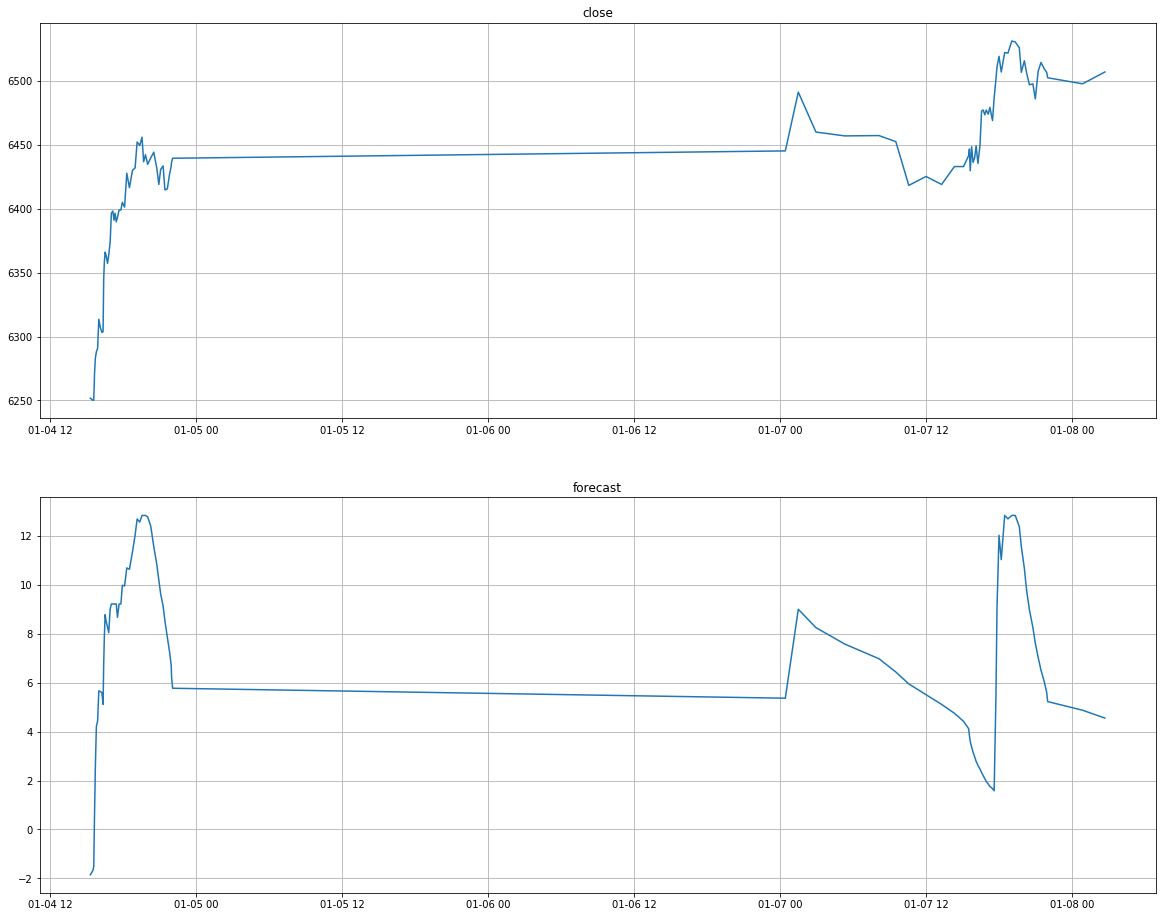

In [14]:
plot(data[['close', 'forecast']].iloc[:100])

In [15]:
out = summary(data, slip=1.5)
out.stats

,0,3,5,6,7,10,15,17,19
Annual return,0.155124,0.227923,0.177247,0.141332,0.153066,0.0384846,0.00395444,0.0319593,0.04195
Cumulative returns,0.157772,0.231932,0.1803,0.143729,0.155675,0.0391073,0.00401733,0.0324747,0.0426298
Annual volatility,0.151705,0.133595,0.123883,0.115509,0.112472,0.0955763,0.0748429,0.0646179,0.0523278
Sharpe ratio,1.02649,1.6041,1.37935,1.20231,1.32269,0.442731,0.0899856,0.519024,0.811402
Calmar ratio,1.45864,2.12441,2.23499,1.90704,2.36028,0.345091,0.0476652,0.605607,0.861438
Stability,0.254534,0.533428,0.501853,0.403733,0.470865,0.0300387,0.23269,0.0441813,0.00471401
Max drawdown,-0.106349,-0.107288,-0.0793056,-0.0741105,-0.0648506,-0.11152,-0.0829627,-0.0527723,-0.0486976
Omega ratio,1.18678,1.30361,1.26326,1.22116,1.25131,1.08225,1.01832,1.1283,1.21967
Sortino ratio,1.46774,2.40849,2.06716,1.80268,1.99376,0.644751,0.131421,0.789827,1.30382
Skew,-0.237165,-0.165436,-0.164525,-0.127903,-0.151871,-0.00442288,0.20241,0.42649,0.644587


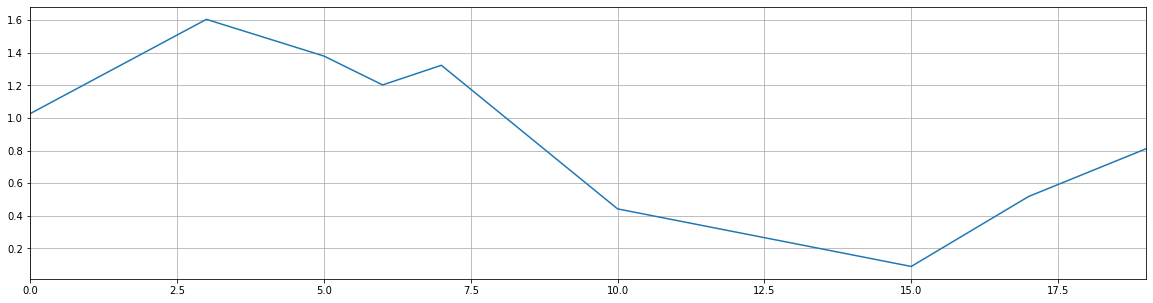

In [16]:
out.stats.loc['Sharpe ratio',].plot(figsize=(20,5), grid=True);

In [17]:
out.returns.corr()

,0,3,5,6,7,10,15,17,19
0,1.000000,0.901116,0.826525,0.776426,0.744700,0.626141,0.518406,0.434162,0.368645
3,0.901116,1.000000,0.935187,0.896556,0.867213,0.749623,0.574224,0.495891,0.413208
5,0.826525,0.935187,1.000000,0.952220,0.921929,0.801425,0.612008,0.534409,0.452074
6,0.776426,0.896556,0.952220,1.000000,0.961690,0.851025,0.645695,0.579296,0.489466
7,0.744700,0.867213,0.921929,0.961690,1.000000,0.878429,0.673378,0.604866,0.497487
10,0.626141,0.749623,0.801425,0.851025,0.878429,1.000000,0.759748,0.708730,0.568405
15,0.518406,0.574224,0.612008,0.645695,0.673378,0.759748,1.000000,0.874162,0.698737
17,0.434162,0.495891,0.534409,0.579296,0.604866,0.708730,0.874162,1.000000,0.792644
19,0.368645,0.413208,0.452074,0.489466,0.497487,0.568405,0.698737,0.792644,1.000000


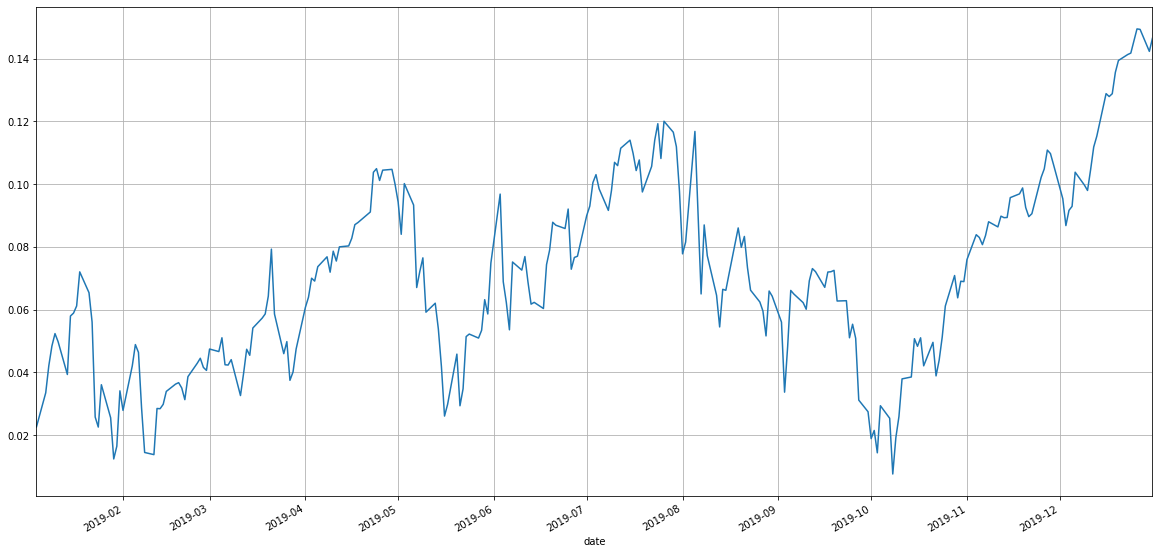

In [18]:
np.log(out.returns[0]+1).cumsum().plot(figsize=(20, 10), grid=True);

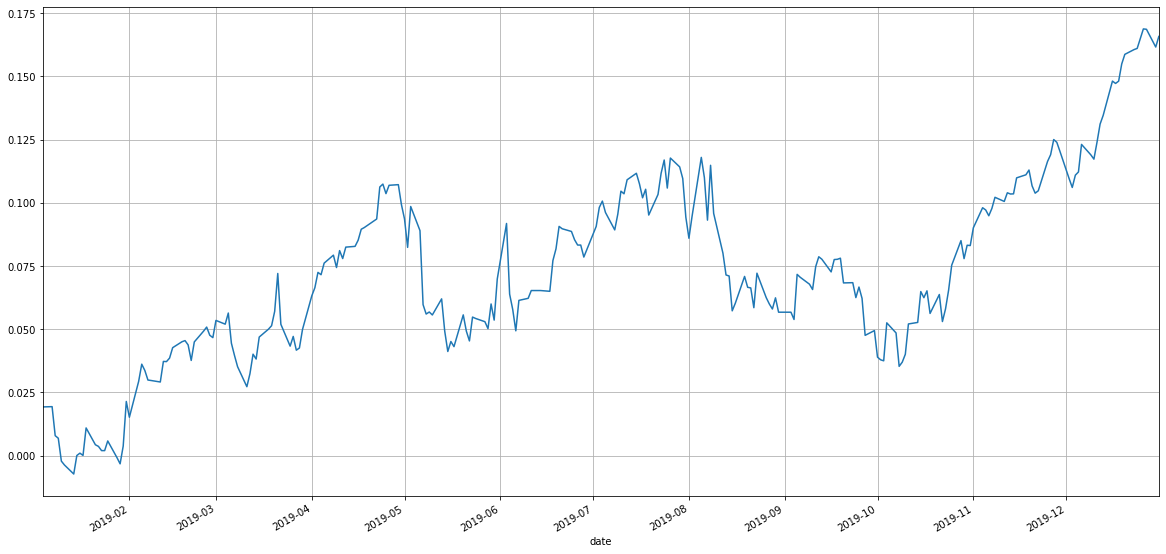

In [19]:
np.log(out.returns[5]+1).cumsum().plot(figsize=(20, 10), grid=True);

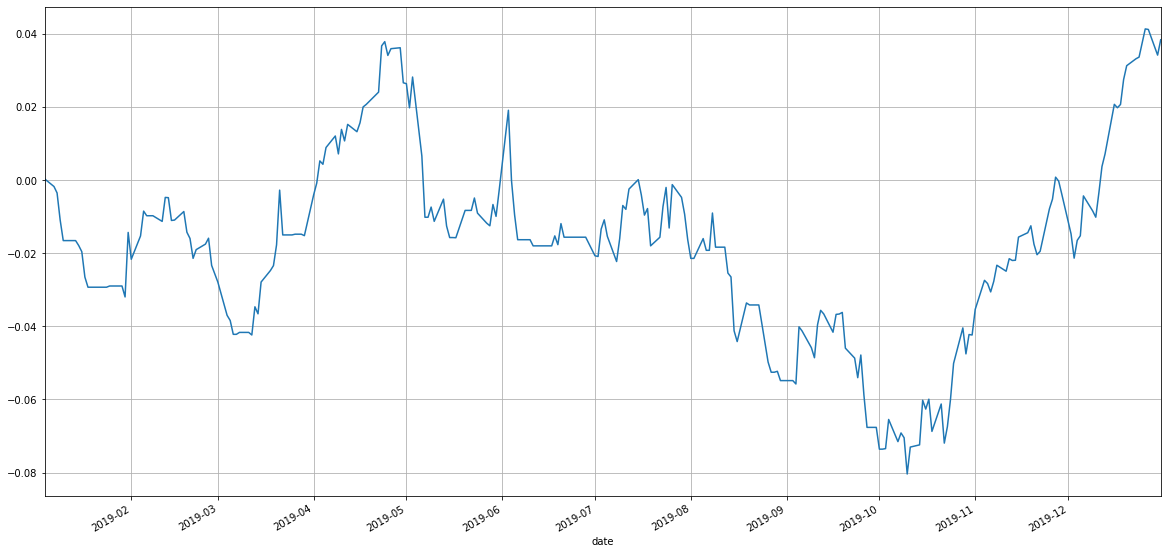

In [20]:
np.log(out.returns[10]+1).cumsum().plot(figsize=(20, 10), grid=True);

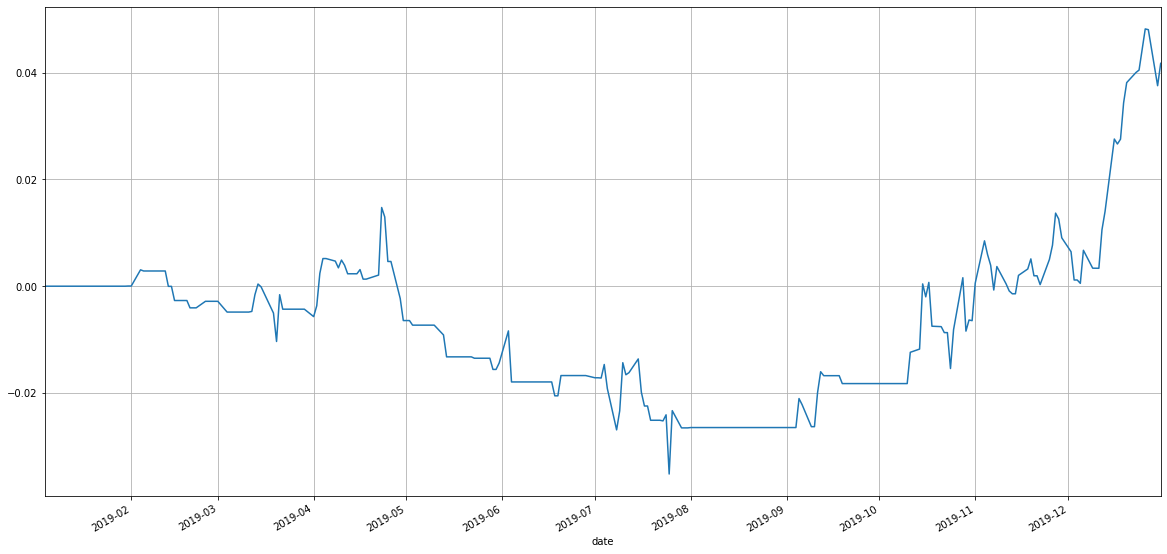

In [21]:
np.log(out.returns[19]+1).cumsum().plot(figsize=(20, 10), grid=True);